# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.02.15

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208

This data is DNA of uncleared MERFISH RNA:
    \\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

31520


# 1. Pre-processing info

In [2]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'save_folder':r'\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208',
             'experiment_type': 'DNA',
             'num_threads': 25,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':10,
                     'max_num_seeds': None,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False
                 }, 
             }

## 1.1 define required floders

In [3]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


50 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots
Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder


In [4]:
pixel_sizes = np.array(fov_param['shared_parameters']['distance_zxy'])
single_im_size = np.array(fov_param['shared_parameters']['single_im_size'])
intensity_th = np.array(fov_param['shared_parameters']['spot_seeding_th'])

In [5]:
# truncate for test
save_fov_ids = save_fov_ids[:5]
save_filenames = save_filenames[:5]

# 2. Partiton spots into cells

## 2.1 (For DNA-only) run segmentation

## (For DNA after dense MERFISH)

In [6]:
# MERFISH segmentation
merfish_segmentation_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear\Segmentation_Cellpose'

# generate alignment
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear'
rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(fov_param['data_folder'], 'Alignment', '10x_positions_after.txt')
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

True True
- Manually picked points aligned, rotation:
[[ 0.99989048 -0.01479949]
 [ 0.01479949  0.99989048]],
 translation:[   50.27017055 -1393.00834786]
-- rotation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\rotation
-- translation matrix saved to file:\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\translation


2022-02-19 19:51:05,846 [INFO] WRITING LOG OUTPUT TO C:\Users\puzheng\.cellpose\run.log
directly load segmentation from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Conv_zscan_000_Segmentation.npy
-- save iamage to file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Figures\Conv_zscan_000_SegmentationMask.png


E:\Users\puzheng\Documents\ImageAnalysis3\figure_tools\plot_segmentation.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


directly load segmentation from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Conv_zscan_001_Segmentation.npy
-- save iamage to file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Figures\Conv_zscan_001_SegmentationMask.png
directly load segmentation from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Conv_zscan_002_Segmentation.npy
-- save iamage to file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Figures\Conv_zscan_002_SegmentationMask.png
directly load segmentation from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Conv_zscan_003_Segmentation.npy
-- save iamage to file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Figures\Conv_zscan_003_SegmentationMask.png
directly load segmentation from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-

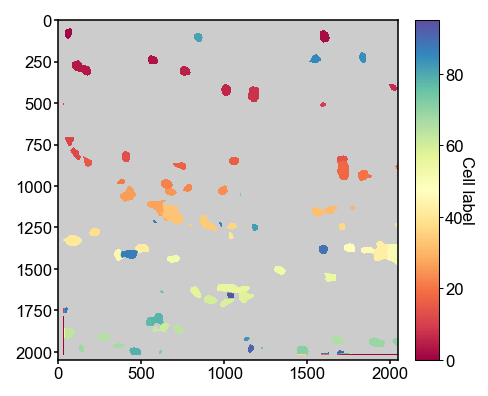

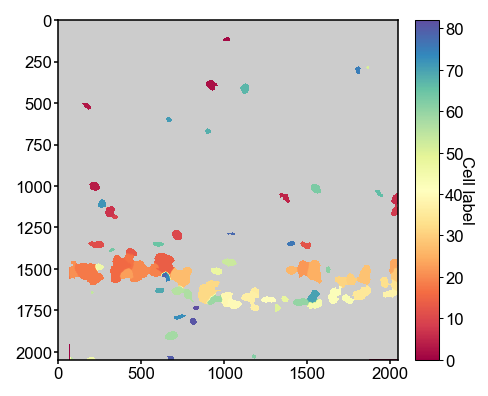

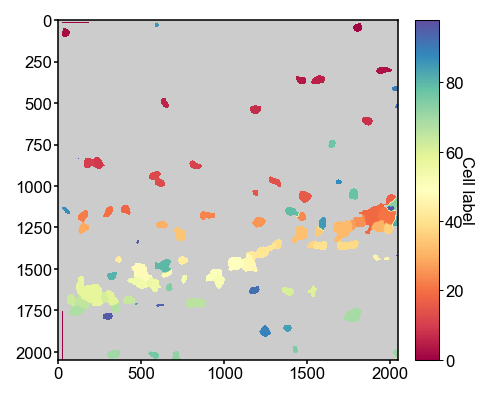

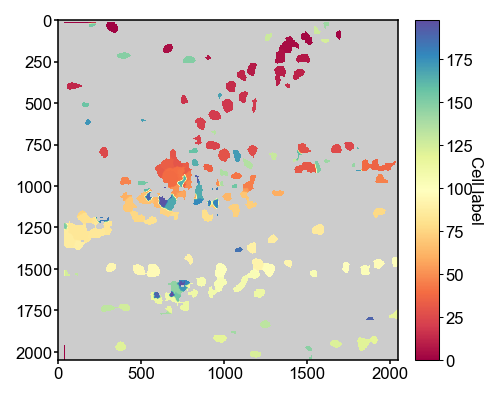

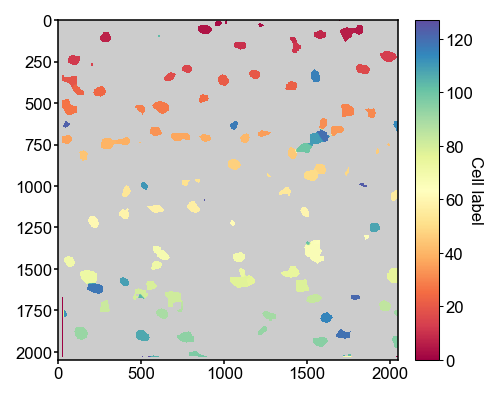

In [7]:
%matplotlib inline
from ImageAnalysis3.segmentation_tools.cell import translate_segmentation
from ImageAnalysis3.figure_tools import plot_segmentation
from scipy.ndimage import grey_dilation

dialation_dimension = 4
overwrite_segmentation = False

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    segmentation_filename = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )
    
    if os.path.exists(segmentation_filename) and not overwrite_segmentation:
        print(f"directly load segmentation from file: {segmentation_filename}")
        dna_mask = np.load(segmentation_filename)
    else:
        print(f"translate segmentation of fov-{_fov_id} from MERFISH")
        # Load DAPI
        with h5py.File(_save_filename, "r", libver='latest') as _f:
            _fov_name = _f.attrs['fov_name']
            # load DAPI
            dapi_im = _f.attrs['dapi_im']
        # load corresponding DAPI and segmentation
        rna_mask_filename = os.path.join(merfish_segmentation_folder, 
                                         _fov_name.replace('.dax', '_Segmentation.npy'))
        rna_mask = np.load(rna_mask_filename)
        rna_dapi_filename = os.path.join(merfish_segmentation_folder, 
                                         _fov_name.replace('.dax', '_Dapi.npy'))
        rna_dapi_im = np.load(rna_dapi_filename)
        # Align
        dna_mask, rot_dapi_im = translate_segmentation(rna_dapi_im, dapi_im, R, 
                                                       label_before=rna_mask, return_new_dapi=True)
        # Do dialation
        dna_mask = grey_dilation(dna_mask, size=dialation_dimension)
        # Save
        print(f"Save segmentation to :{segmentation_filename}")
        np.save(segmentation_filename.replace('.npy',''), dna_mask)
    # Make plot
    mask_savefig = os.path.join(segmentation_folder, 'Figures', 
                                os.path.basename(_save_filename).replace('.hdf5', '_SegmentationMask.png'))
    if not os.path.exists(os.path.dirname(mask_savefig)):
        os.makedirs(os.path.dirname(mask_savefig))
    ax = plot_segmentation.plot_segmentation(dna_mask, save_filename=mask_savefig)
    

## 2.2 Partition spots

In [9]:
from ImageAnalysis3.meta_tools.partition_spots import Spots_Partition
reload(ia.meta_tools.partition_spots)
from ImageAnalysis3.classes.preprocess import Spots3D

from ImageAnalysis3.figure_tools import plot_partition

import pandas as pd

In [10]:
%%time
%matplotlib inline

search_radius = 4
overwrite_cand_spots = False

# create all info
fov_2_spots_df = {}

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation 
    segmentation_filename = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )
    print(f"Load Segmentation from file: {segmentation_filename}")
    seg_label = np.load(segmentation_filename)
    
    # savename
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.exists(cand_spot_filename) and not overwrite_cand_spots:
        print(f"Directly load cand_spots from file: {cand_spot_filename}")
        fov_2_spots_df[_fov_id] = pd.read_csv(cand_spot_filename)
    else:
        print(f"Partition spots for fov-{_fov_id}")

        ## Load spots and their info
        with h5py.File(_save_filename, "r", libver='latest') as _f:
            _grp = _f['combo']
            combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['spots'][:]]
            raw_combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['raw_spots'][:]]
            combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
            combo_ids = _grp['ids'][:]

        ## partition
        cell_2_spots = {_c:{} for _c in np.arange(1, np.max(seg_label)+1)}
        cell_2_raw_spots = {_c:{} for _c in np.arange(1, np.max(seg_label)+1)}
        label_dict = {}

        for _id, _pts, _raw_pts in zip(combo_ids, combo_spots_list, raw_combo_spots_list):
            # cast spot class
            _spots = Spots3D(_pts, bits=_id, pixel_sizes=pixel_sizes)
            _raw_spots = Spots3D(_pts, bits=_id, pixel_sizes=pixel_sizes)
            # calculate labels
            _labels = Spots_Partition.spots_to_labels(seg_label, _spots, search_radius=search_radius)
            label_dict[_id] = _labels
            # parittion
            for _l in np.unique(_labels):
                if _l > 0:
                    _keep_flags = (_labels==_l)
                    # append
                    cell_2_spots[_l][_id] = _spots[_keep_flags]
                    cell_2_spots[_l][_id].bits = _spots.bits[_keep_flags]
                    cell_2_raw_spots[_l][_id] = _raw_spots[_keep_flags]
                    cell_2_raw_spots[_l][_id].bits = _raw_spots.bits[_keep_flags]
        ## plot stats
        cell_spots_counts = []
        for _cell, _spots_dict in cell_2_spots.items():
            _spots_counts = []
            for _bit in combo_ids:
                if _bit in _spots_dict:
                    _spots_counts.append(len(_spots_dict[_bit]))
                else:
                    _spots_counts.append(0)
            cell_spots_counts.append(np.array(_spots_counts))
        cell_spots_counts = np.array(cell_spots_counts)

        count_savefig = os.path.join(cand_spot_folder, 'Figures', 
                                     os.path.basename(_save_filename).replace('.hdf5', '_SpotCountPerCell.png'))
        if not os.path.exists(os.path.dirname(count_savefig)):
            os.makedirs(os.path.dirname(count_savefig))
        # Plot
        count_ax = plot_partition.plot_cell_spot_counts(cell_spots_counts, save=True, save_filename=count_savefig)

        from ImageAnalysis3.io_tools.spots import FovCell2Spots_2_DataFrame
        # bit_2_channel
        bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

        spots_df = FovCell2Spots_2_DataFrame(cell_2_spots, _fov_id, bit_2_channel, save_filename=cand_spot_filename)

        # append
        fov_2_spots_df[_fov_id] = spots_df
        

Load Segmentation from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Conv_zscan_000_Segmentation.npy
Directly load cand_spots from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots\Conv_zscan_000_CandSpots.csv
Load Segmentation from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Conv_zscan_001_Segmentation.npy
Directly load cand_spots from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots\Conv_zscan_001_CandSpots.csv
Load Segmentation from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Conv_zscan_002_Segmentation.npy
Directly load cand_spots from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots\Conv_zscan_002_CandSpots.csv
Load Segmentation from file: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Segmentation\Conv_zs

In [11]:
%%time
# decide fovs to merge
merge_fov_ids = save_fov_ids #[1,2,3,4]
merged_spots_df = pd.DataFrame([], columns=fov_2_spots_df[merge_fov_ids[0]].columns)
for _fov_id in merge_fov_ids:
    merged_spots_df = merged_spots_df.append(fov_2_spots_df[merge_fov_ids[_fov_id]], ignore_index=True )

Wall time: 3.8 s


In [12]:
merged_spots_df

,fov_id,cell_id,height,z,x,y,background,sigma_z,sigma_x,sigma_y,sin_t,sin_p,eps,bit,channel,pixel_z,pixel_x,pixel_y
0,0,1,8202.493164,9.285052,89.580498,72.475677,16403.648438,1.803174,1.799484,1.985787,-1.000000,1.000000,951.284668,1,750,250,108,108
1,0,1,7974.637695,6.289665,88.340569,75.954262,15513.007812,2.412709,3.375523,2.518691,1.000000,-0.315940,633.199219,1,750,250,108,108
2,0,1,6671.041016,13.346459,82.555656,68.370300,15637.180664,1.779254,2.786402,2.485028,-0.916995,-0.645588,514.142944,1,750,250,108,108
3,0,1,7350.330566,9.333898,74.827011,90.015114,15739.626953,2.323035,1.446380,1.417549,0.200427,-0.071362,431.889069,1,750,250,108,108
4,0,1,6740.455078,4.114094,93.616501,68.668106,15617.937500,2.828729,1.947460,1.947912,0.402324,-0.351180,487.082428,1,750,250,108,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4033162,4,127,4011.067871,44.024834,2023.200195,539.410767,15612.267578,2.412099,1.692661,1.665217,-0.196431,0.104954,269.948029,97,750,250,108,108
4033163,4,127,2068.927246,35.234371,2025.903687,530.701416,6115.576660,1.956712,1.463527,1.516797,0.024568,-0.033063,183.671265,98,647,250,108,108
4033164,4,127,8497.425781,42.281387,2033.090698,538.906982,15369.012695,2.408935,1.561109,1.543178,0.060746,0.204461,299.386475,99,750,250,108,108
4033165,4,127,3441.724609,41.804958,2019.310303,547.242065,15286.523438,2.493999,1.748819,1.568620,0.114262,0.095256,224.504517,99,750,250,108,108


In [28]:
# Save
merged_spots_filename = os.path.join(cand_spot_folder, 
    f"merged_CandSpots_fov-{min(merge_fov_ids)}-{max(merge_fov_ids)}.csv")
print(merged_spots_filename)
merged_spots_df.to_csv(merged_spots_filename, index=False)

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\CandSpots\merged_CandSpots_fov-0-4.csv


# 3. Test Decoding

## 3.1 load codebook

In [13]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910,chr,chr_order
0,1:3740000-3760000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:6240000-6260000,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1:8740000-8760000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,1:11240000-11260000,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,1:13740000-13760000,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,X:161240000-161260000,1057,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,X,52
984,X:163740000-163760000,1058,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,X,53
985,X:166240000-166260000,1059,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,X,54
986,X:168740000-168760000,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,55


## 3.2 load spot files

In [29]:
merge_fov_ids = save_fov_ids
merged_spots_filename = os.path.join(cand_spot_folder, 
    f"merged_CandSpots_fov-{min(merge_fov_ids)}-{max(merge_fov_ids)}.csv")
# Load
merged_spots_df = pd.read_csv(merged_spots_filename)
# create necessary dict
bit_2_channel = {}
for _b in np.unique(merged_spots_df['bit']):
    _ch = np.unique(merged_spots_df.loc[merged_spots_df['bit']==_b, 'channel'])
    bit_2_channel[_b] = str(_ch[0])

2022-02-19 19:36:33,187 [INFO] Note: NumExpr detected 44 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-02-19 19:36:33,188 [INFO] NumExpr defaulting to 8 threads.


In [16]:
with h5py.File(_save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]
    
bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

## 3.3 test decode one cell

In [20]:
%%time
from ImageAnalysis3.classes import decode
reload(decode)
overwrite = True

overwrite_decoder = True
pair_search_radius = 250

decode_args = []
for _fov_id in np.unique(merged_spots_df['fov_id']):
    _fov_spots_df = merged_spots_df[merged_spots_df['fov_id']==_fov_id]
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        print(_fov_id, _cell_id)
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f'Fov-{_fov_id}_Cell-{_cell_id}_Decoder.pkl')
        _args = (_cell_spots_df, codebook_df, _decoder_filename, 
                 False, True, bit_2_channel,
                 pixel_sizes, 2, 0.4, 
                 pair_search_radius, -1, 1, 5, 0, -25, 
                 False, overwrite_decoder, True, False) 
        # append
        decode_args.append(_args)
print(len(decode_args))

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 

In [26]:
_cell_spots_df

,fov_id,cell_id,height,z,x,y,background,sigma_z,sigma_x,sigma_y,sin_t,sin_p,eps,bit,channel,pixel_z,pixel_x,pixel_y
4032941,4,127,8971.544922,33.656239,2036.868896,524.199829,15629.710938,2.981238,1.951209,1.958451,-0.007172,-0.012223,538.133667,1,750,250,108,108
4032942,4,127,9165.945312,37.840446,2040.669678,542.355713,15697.597656,2.498738,1.596066,1.454063,-0.028053,0.123130,417.964417,1,750,250,108,108
4032943,4,127,3242.293213,38.213089,2038.784546,536.687622,15729.926758,3.810002,1.453360,1.578901,0.065598,-0.153247,305.518829,1,750,250,108,108
4032944,4,127,2112.441650,36.090244,2030.433594,524.361511,15006.617188,3.999998,2.495322,1.897520,0.572397,-0.037883,266.005676,1,750,250,108,108
4032945,4,127,7906.857910,34.120327,2036.548828,522.947388,7264.358887,3.582960,1.796297,1.860741,-0.282088,0.375617,597.277466,2,647,250,108,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4033162,4,127,4011.067871,44.024834,2023.200195,539.410767,15612.267578,2.412099,1.692661,1.665217,-0.196431,0.104954,269.948029,97,750,250,108,108
4033163,4,127,2068.927246,35.234371,2025.903687,530.701416,6115.576660,1.956712,1.463527,1.516797,0.024568,-0.033063,183.671265,98,647,250,108,108
4033164,4,127,8497.425781,42.281387,2033.090698,538.906982,15369.012695,2.408935,1.561109,1.543178,0.060746,0.204461,299.386475,99,750,250,108,108
4033165,4,127,3441.724609,41.804958,2019.310303,547.242065,15286.523438,2.493999,1.748819,1.568620,0.114262,0.095256,224.504517,99,750,250,108,108


In [34]:
reload(ia.io_tools.spots)

<module 'ImageAnalysis3.io_tools.spots' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\io_tools\\spots.py'>

- 6683 pairs kept given search radius 250 nm.
2022-02-19 20:05:27,794 [INFO] Note: NumExpr detected 44 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-02-19 20:05:27,795 [INFO] NumExpr defaulting to 8 threads.
- search spot_groups given search radius 250 nm, max_usage=1


100%|███████████████████████████████████████████████████████████████| 6683/6683 [00:00<00:00, 102739.55it/s]


- 1830 spot_groups detected
- split found tuples into chromosomes. 
- generate randomized spot pairs 
- generate chr_2_kdtree. 
-- seeding chr:1 with 77 regions with 90 spot_groups
- diff in iter-0: 0.6444
- diff in iter-1: 0.0333
- diff in iter-2: 0.0222
- diff in iter-3: 0.0111
- diff in iter-4: 0.0000
-- seeding chr:10 with 51 regions with 68 spot_groups
- diff in iter-0: 0.6324
- diff in iter-1: 0.0294
- diff in iter-2: 0.0294
- diff in iter-3: 0.1029
- diff in iter-4: 0.0294
- diff in iter-5: 0.0294
- diff in iter-6: 0.0441
- diff in iter-7: 0.0441
- diff in iter-8: 0.0000
-- seeding chr:11 with 48 regions with 127 spot_groups
- diff in iter-0: 0.5276
- diff in iter-1: 0.0472
- diff in iter-2: 0.0236
- diff in iter-3: 0.0157
- diff in iter-4: 0.0000
-- seeding chr:12 with 43 regions with 65 spot_groups
- diff in iter-0: 0.6769
- diff in iter-1: 0.0615
- diff in iter-2: 0.0923
- diff in iter-3: 0.0308
- diff in iter-4: 0.0308
- diff in iter-5: 0.0000
-- seeding chr:13 with 45 regio

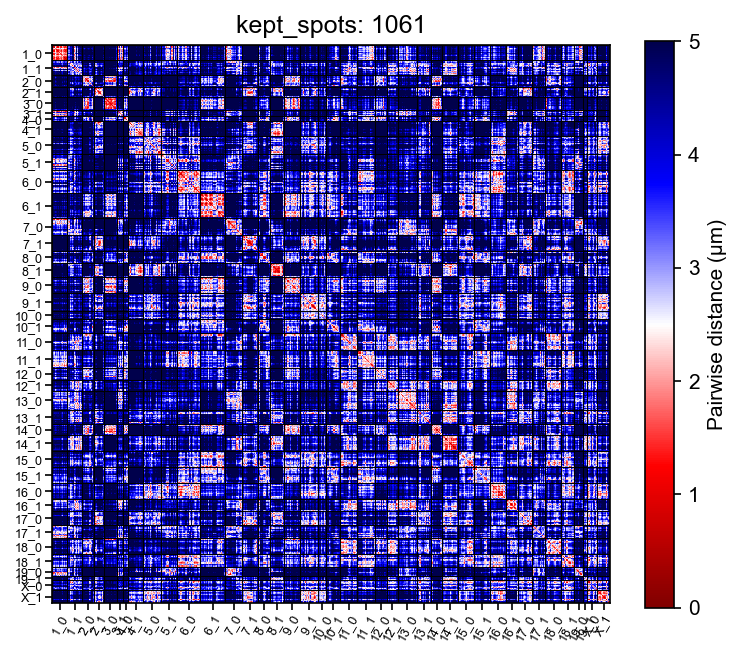

In [35]:
# test run one cell
%matplotlib inline
reload(decode)
_cell_ind = 10
decoder = decode.batch_decode_DNA(*decode_args[_cell_ind])

In [36]:
sc,dc = 0,0
for _ig, _group in enumerate(decoder.spot_groups):
    #print(_ig, _group.bits)
    if combo_channels[_group.bits[0]-1] == combo_channels[_group.bits[1]-1]:
        sc += 1
    else:
        dc += 1
print(sc,dc)

1066 764


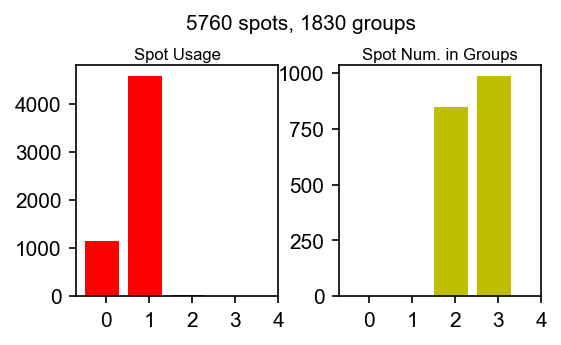

In [37]:
from ImageAnalysis3.figure_tools import plot_decode
reload(figure_tools.plot_decode)
plot_decode.plot_spot_stats(decoder.spot_groups, decoder.spot_usage,
                            show_image=False)

## visualize decoded spots

In [38]:
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder
Use decode_figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Figures


<IPython.core.display.Javascript object>


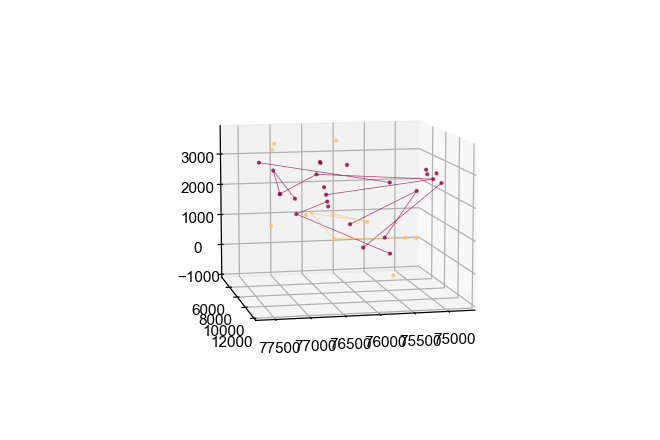

In [43]:
%matplotlib notebook

def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')

_zxys_list = decoder.chr_2_zxys_list['3']

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               #cmap=Spectral, 
               color=Spectral(_ichr/(len(_zxys_list)+1)),
               #c=homolog_labels,
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
fig.show()

## 3.4 process all

In [44]:
%%time
# old version
import multiprocessing as mp

print(len(decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

596
Wall time: 20min 15s


# 5. Summarize decoder

This step will detect all decoder files so it will merge fovs

In [45]:
#decoder_folder = os.path.join(save_folder, 'Decoder')
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in os.listdir(decoder_folder) 
                     if '_Decoder.pkl' in _fl]
print(decoder_folder, len(decoder_filenames))

\\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder 450


In [46]:
%%time
import multiprocessing as mp
load_args = [(_fl, 'chr_2_zxys_list') for _fl in decoder_filenames]
print(len(load_args))
with mp.Pool(44) as load_pool:
    all_chr_2_zxys_list = load_pool.starmap(decode.batch_load_attr, 
                                            load_args, chunksize=1)
    load_pool.close()
    load_pool.join()
    load_pool.terminate()

# summarize
decode_filenames = [_fl for _fl,_item in zip(decoder_filenames, all_chr_2_zxys_list) if _item is not None]
all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
print(len(all_chr_2_zxys_list))

450
450
Wall time: 23.7 s


In [47]:
%%time
import multiprocessing as mp
summary_args = [(_item, codebook_df) for _item in all_chr_2_zxys_list ]

print(len(summary_args))

with mp.Pool(44) as summary_pool: 
    all_zxys_list = summary_pool.starmap(decode.DNA_Merfish_Decoder.summarize_zxys_by_regions, 
                                         summary_args, chunksize=1)
    summary_pool.close()
    summary_pool.join()
    summary_pool.terminate()

450
Wall time: 35.9 s


In [55]:
all_zxys = np.concatenate(all_zxys_list)
loss_rates = np.mean(np.isnan(all_zxys).any(2), axis=0)
plt.figure()
plt.plot(1-loss_rates)
plt.ylim([0,1])
plt.xlabel('Regions')
plt.ylabel('Detection rate')
plt.show()

<IPython.core.display.Javascript object>

In [49]:
%%time
from scipy.spatial.distance import cdist,pdist,squareform
from tqdm import tqdm

all_zxys = np.concatenate(all_zxys_list)
#all_zxys = np.array(decode_save_dict['zxys'])

all_distmaps = [squareform(pdist(_zxys)) for _zxys in tqdm(all_zxys)]

from ImageAnalysis3.classes import postanalysis
median_distmap = postanalysis.parallel_reduce_matrix(all_distmaps, function='nanmedian', axis=0,
                                                     num_threads=44)

100%|█████████████████████████████████████████████████████████████████████| 900/900 [00:12<00:00, 69.49it/s]


Wall time: 43.4 s


In [50]:
%%time
all_contactmaps = np.array(all_distmaps) <= 0.5

contactmap = postanalysis.parallel_reduce_matrix(all_contactmaps, function='nanmean', axis=0,
                                                     num_threads=44)


Wall time: 13.1 s


In [51]:
save_figure = True
#figure_folder = os.path.join(save_folder, 'Figures_final')
figure_folder = os.path.join(decoder_folder, 'Figures_final')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")

Use figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220215-P_brain_CTP11-1000_CTP12_from0208\Decoder\Figures_final


In [52]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

In [53]:
from matplotlib.colors import LogNorm
from matplotlib import cm

contact_limits = [0.005, 0.04]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = cm.get_cmap('Reds')
contact_cmap.set_bad(color=[0.,0.,0.,1])

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(
    contactmap, 
    cmap=contact_cmap,
    color_limits=contact_limits,
    color_norm=contact_norm,
    colorbar_labels='Contact frequency',
    ax=ax,
)

ax.set_title(f'Contact freq, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_contact_map.png'), transparent=True)
fig.show()


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  


<IPython.core.display.Javascript object>

E:\Users\puzheng\Documents\ImageAnalysis3\figure_tools\distmap.py:39: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmin=min(color_limits), vmax=max(color_limits), **imshow_kwargs)


<IPython.core.display.Javascript object>


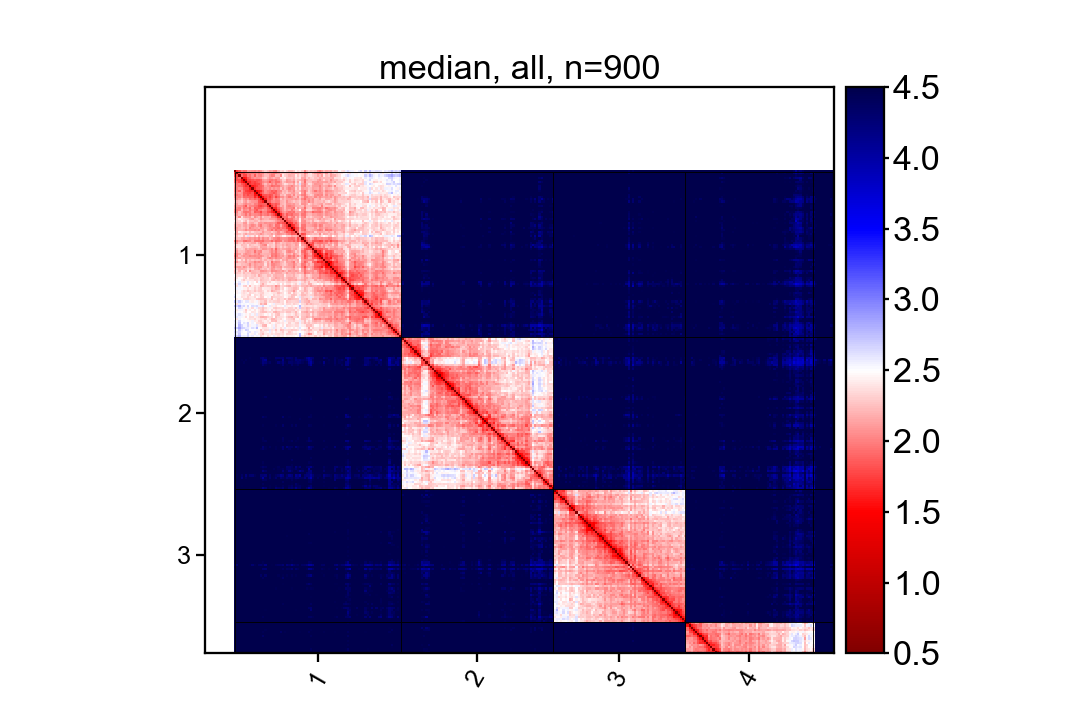

In [54]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(median_distmap, color_limits=[0.5,4.5],
                                          ax=ax,
                                          )
ax.set_title(f'median, all, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_median_distmap.png'), transparent=True)
fig.show()